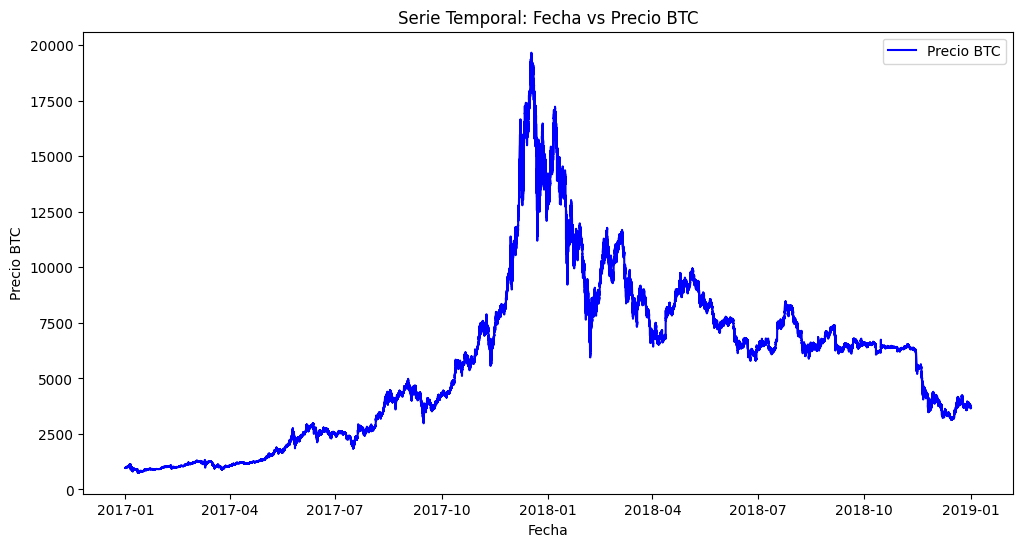

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Cargar datos
#df_2017 = pd.read_csv('BTC-2017min.csv')
#df_2018 = pd.read_csv('BTC-2018min.csv')

#df = pd.concat([df_2017, df_2018], ignore_index=True)

# Convertir la columna "date" a objeto datetime y ordenar cronológicamente
#df['datetime'] = pd.to_datetime(df['date'])
#df = df.sort_values('datetime').reset_index(drop=True)


# --- 1. Cargar y combinar datasets ---
# Lista de archivos. En el futuro, solo agregas nuevos nombres a esta lista.
files = ['BTC-2017min.csv', 'BTC-2018min.csv']  # Puedes agregar 'BTC-2019min.csv', etc.

# Función para cargar y procesar cada archivo
def load_and_process(file):
    df = pd.read_csv(file)
    # Convertir la columna "date" a datetime
    df['datetime'] = pd.to_datetime(df['date'])
    # Ordenar cronológicamente
    df = df.sort_values('datetime').reset_index(drop=True)
    return df

# Cargar todos los archivos y concatenarlos
dfs = [load_and_process(file) for file in files]
df = pd.concat(dfs, ignore_index=True)
df = df.sort_values('datetime').reset_index(drop=True)

# --- 2. Visualización inicial de la serie temporal ---
plt.figure(figsize=(12, 6))
plt.plot(df['datetime'], df['close'], label='Precio BTC', color='blue')
plt.xlabel('Fecha')
plt.ylabel('Precio BTC')
plt.title('Serie Temporal: Fecha vs Precio BTC')
plt.legend()
plt.show()

# Explorar las primeras filas
#print(df.head())
# Información general del dataset
#print(df.info())
# Estadísticas descriptivas
#print(df.describe())

# Para calcular RSI, se necesitan cálculos adicionales
# A modo ilustrativo, supongamos que creas una función
# def compute_rsi(series, period=14):
#    delta = series.diff()
#    up = delta.clip(lower=0)
#    down = -1*delta.clip(upper=0)
#    ma_up = up.rolling(period).mean()
#    ma_down = down.rolling(period).mean()
#    rsi = 100 - (100/(1 + ma_up/ma_down))
#    return rsi

# --- 3. Feature Engineering ---
# Se calculan variables adicionales que pueden ser útiles.
df['returns'] = df['close'].pct_change() * 100   

# Calcular media móvil de 7 días
df['moving_avg_7'] = df['close'].rolling(window=7).mean()

# Calcular volatilidad (desviación estándar de 7 días)
df['volatility'] = df['close'].rolling(window=7).std()

#df['rsi'] = compute_rsi(df['close'], period=14)

# Eliminar filas con valores nulos (por ejemplo, las primeras debido a cálculos)
df.dropna(inplace=True)

# --- 4. Selección de features y escalado ---
features = ['open', 'high', 'low', 'Volume BTC', 'Volume USD', 
            'returns', 'moving_avg_7', 'volatility']
X = df[features]
y = df['close']
# Normalizar características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



In [25]:

# --- 5. División train/test (respeta la secuencia temporal) ---
# Se usa el 80% de los datos para entrenar y el 20% para test
train_size = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
dates_train = df['datetime'][:train_size]
dates_test = df['datetime'][train_size:]

In [ ]:
# --- 6. Entrenar varios modelos clásicos ---

# 6.1 KNN con GridSearchCV (usando 8 núcleos)
tscv = TimeSeriesSplit(n_splits=5)
knn = KNeighborsRegressor(n_jobs=8)
param_grid_knn = {
    'n_neighbors': range(3, 15),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=tscv,
                               scoring='neg_mean_squared_error', n_jobs=8)
grid_search_knn.fit(X_train, y_train)
best_knn = grid_search_knn.best_estimator_
print(f"Mejor n_neighbors: {grid_search.best_params_}")
y_pred_knn = best_knn.predict(X_test)

# 6.2 Regresión Lineal
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred_linreg = linreg.predict(X_test)

# 6.3 Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=8)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# 6.4 SVR (Support Vector Regression)
svr = SVR(kernel='rbf')
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)


Mejor n_neighbors: {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}


In [ ]:
# --- 7. Evaluación de los Modelos ---
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, rmse, r2

metrics_knn = evaluate_model(y_test, y_pred_knn)
metrics_linreg = evaluate_model(y_test, y_pred_linreg)
metrics_rf = evaluate_model(y_test, y_pred_rf)
metrics_svr = evaluate_model(y_test, y_pred_svr)

results = pd.DataFrame({
    'Modelo': ['KNN', 'Regresión Lineal', 'Random Forest', 'SVR'],
    'MSE': [metrics_knn[0], metrics_linreg[0], metrics_rf[0], metrics_svr[0]],
    'MAE': [metrics_knn[1], metrics_linreg[1], metrics_rf[1], metrics_svr[1]],
    'RMSE': [metrics_knn[2], metrics_linreg[2], metrics_rf[2], metrics_svr[2]],
    'R²': [metrics_knn[3], metrics_linreg[3], metrics_rf[3], metrics_svr[3]]
})
print(results)


MSE: 7978.424546062135
MAE: 57.502425577780755


In [ ]:
# despliegue de la solución

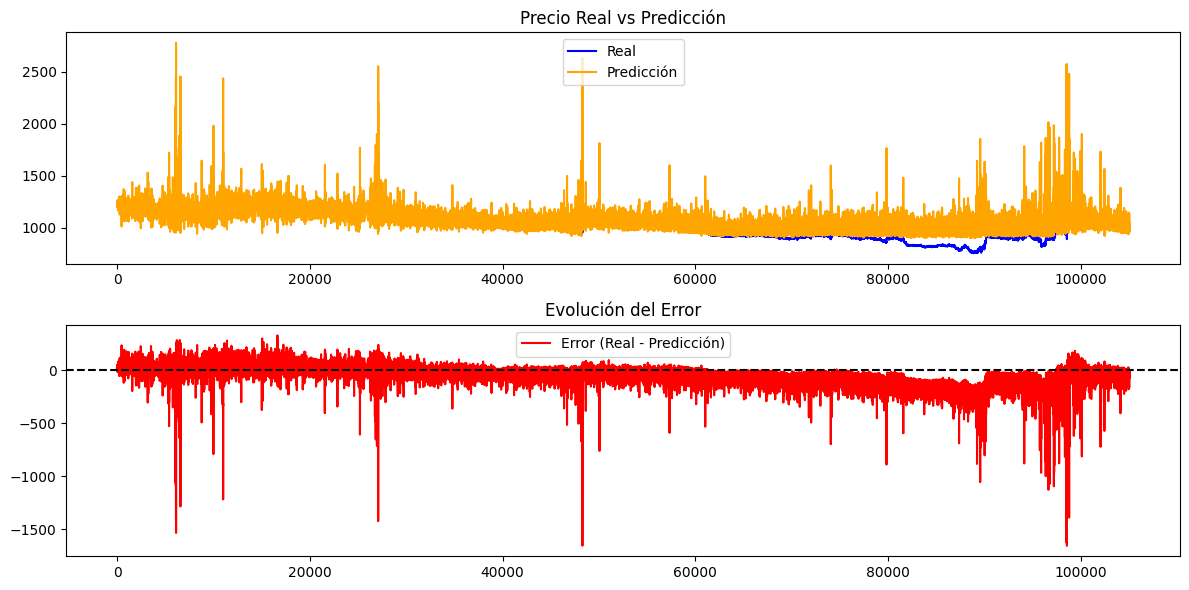

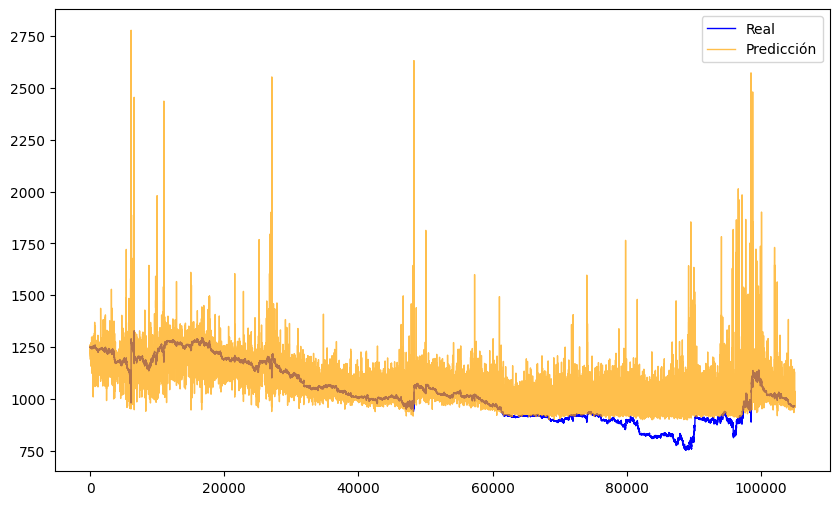

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- 1. Cargar y combinar datasets ---
# Lista de archivos. En el futuro, solo agregas nuevos nombres a esta lista.
files = ['BTC-2017min.csv', 'BTC-2018min.csv']  # Puedes agregar 'BTC-2019min.csv', etc.

# Función para cargar y procesar cada archivo
def load_and_process(file):
    df = pd.read_csv(file)
    # Convertir la columna "date" a datetime
    df['datetime'] = pd.to_datetime(df['date'])
    # Ordenar cronológicamente
    df = df.sort_values('datetime').reset_index(drop=True)
    return df

# Cargar todos los archivos y concatenarlos
dfs = [load_and_process(file) for file in files]
df = pd.concat(dfs, ignore_index=True)
df = df.sort_values('datetime').reset_index(drop=True)

# --- 2. Visualización inicial de la serie temporal ---
plt.figure(figsize=(12, 6))
plt.plot(df['datetime'], df['close'], label='Precio BTC', color='blue')
plt.xlabel('Fecha')
plt.ylabel('Precio BTC')
plt.title('Serie Temporal: Fecha vs Precio BTC')
plt.legend()
plt.show()

# --- 3. Feature Engineering ---
# Se calculan variables adicionales que pueden ser útiles.
df['returns'] = df['close'].pct_change() * 100      # Retornos porcentuales
df['moving_avg_7'] = df['close'].rolling(window=7).mean()   # Media móvil de 7 periodos
df['volatility'] = df['close'].rolling(window=7).std()      # Volatilidad en 7 periodos

# Eliminar filas con valores nulos (por ejemplo, las primeras debido a cálculos)
df.dropna(inplace=True)

# --- 4. Selección de features y escalado ---
features = ['open', 'high', 'low', 'Volume BTC', 'Volume USD', 
            'returns', 'moving_avg_7', 'volatility']
X = df[features]
y = df['close']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 5. División train/test (respeta la secuencia temporal) ---
# Se usa el 80% de los datos para entrenar y el 20% para test
train_size = int(len(X_scaled) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
dates_train = df['datetime'][:train_size]
dates_test = df['datetime'][train_size:]

# --- 6. Entrenar varios modelos clásicos ---

# 6.1 KNN con GridSearchCV (usando 8 núcleos)
tscv = TimeSeriesSplit(n_splits=5)
knn = KNeighborsRegressor(n_jobs=8)
param_grid_knn = {
    'n_neighbors': range(3, 15),
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=tscv,
                               scoring='neg_mean_squared_error', n_jobs=8)
grid_search_knn.fit(X_train, y_train)
best_knn = grid_search_knn.best_estimator_
y_pred_knn = best_knn.predict(X_test)

# 6.2 Regresión Lineal
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred_linreg = linreg.predict(X_test)

# 6.3 Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=8)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# 6.4 SVR (Support Vector Regression)
svr = SVR(kernel='rbf')
svr.fit(X_train, y_train)
y_pred_svr = svr.predict(X_test)

# --- 7. Evaluación de los Modelos ---
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, mae, rmse, r2

metrics_knn = evaluate_model(y_test, y_pred_knn)
metrics_linreg = evaluate_model(y_test, y_pred_linreg)
metrics_rf = evaluate_model(y_test, y_pred_rf)
metrics_svr = evaluate_model(y_test, y_pred_svr)

results = pd.DataFrame({
    'Modelo': ['KNN', 'Regresión Lineal', 'Random Forest', 'SVR'],
    'MSE': [metrics_knn[0], metrics_linreg[0], metrics_rf[0], metrics_svr[0]],
    'MAE': [metrics_knn[1], metrics_linreg[1], metrics_rf[1], metrics_svr[1]],
    'RMSE': [metrics_knn[2], metrics_linreg[2], metrics_rf[2], metrics_svr[2]],
    'R²': [metrics_knn[3], metrics_linreg[3], metrics_rf[3], metrics_svr[3]]
})
print(results)

# --- 8. Gráficos Comparativos de Evaluación ---

plt.figure(figsize=(12, 8))
# MSE
plt.subplot(2,2,1)
plt.bar(results['Modelo'], results['MSE'], color='skyblue')
plt.title('MSE')
plt.ylabel('Error Cuadrático Medio')

# MAE
plt.subplot(2,2,2)
plt.bar(results['Modelo'], results['MAE'], color='lightgreen')
plt.title('MAE')
plt.ylabel('Error Absoluto Medio')

# RMSE
plt.subplot(2,2,3)
plt.bar(results['Modelo'], results['RMSE'], color='salmon')
plt.title('RMSE')
plt.ylabel('Raíz del MSE')

# R²
plt.subplot(2,2,4)
plt.bar(results['Modelo'], results['R²'], color='plum')
plt.title('R²')
plt.ylabel('Coeficiente de Determinación')

plt.tight_layout()
plt.show()

# --- 9. Visualización del Pronóstico vs. la Serie Real (usando fecha) ---
# Por ejemplo, se muestra la comparación para el modelo Random Forest
plt.figure(figsize=(12, 6))
plt.plot(dates_test, y_test.values, label='Precio Real', color='blue')
plt.plot(dates_test, y_pred_rf, label='Predicción Random Forest', color='orange', linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Precio BTC')
plt.title('Comparación: Precio Real vs. Predicción (Random Forest)')
plt.legend()
plt.show()
